<a href="https://colab.research.google.com/github/lschoch/MLA_LHS/blob/main/MLA2_LHS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Machine Learning Assignment 2**  
## **Lawrence Schoch**
## **CS430**
## **Machine Learning in the Cloud** 
---

## Standard Imports

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [93]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Imports for specific models
In this section, you will import the models from SKLearn that you will use this in this notebook. 

In [94]:
# Import the LinearRegression model.
from sklearn.linear_model import LinearRegression
# Import the LogisticRegression model.
from sklearn.linear_model import LogisticRegression

## Imports for Splitting Data and Building Pipeline


In [95]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display='diagram')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# Imports for Performance Measures

In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

## Confusion Matrix Function
This function is for creating a graphical version of the confusion matrix.



In [97]:
def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    fig = plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
    plt.ylabel('True label')
    plt.xlabel('Predicted Label')

# ROC_Curve Function
This function is for plotting the roc_curve

In [98]:
def plot_roc_curve(fpr,tpr):
  plt.figure(figsize=(10, 10))
  plt.title('ROC Curve')
  plt.plot(fpr, tpr, linewidth=2)
  plt.plot([0,1],[0,1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('Recall (True Positive Rate)')


## Problem 1

### Reading the Data

In [99]:
df = pd.read_csv('/content/gdrive/MyDrive/1CS430/Steel_industry_data.csv')

### Rename the Columns According to Table 1: Column Names

In [100]:
df.rename(columns = {'Usage_kWh':'usage_kwh'},inplace=True)
df.rename(columns = {'Lagging_Current_Reactive.Power_kVarh':'lag_react_pwr_kvarh'},inplace=True)
df.rename(columns = {'Leading_Current_Reactive_Power_kVarh':'lead_react_pwr_kvarh'},inplace=True)
df.rename(columns = {'Lagging_Current_Power_Factor':'lag_current_pwr'},inplace=True)
df.rename(columns = {'Leading_Current_Power_Factor':'lead_current_pwr'},inplace=True)
df.rename(columns = {'NSM':'nsm'},inplace=True)
df.rename(columns = {'WeekStatus':'week_status'},inplace=True)
df.rename(columns = {'Day_of_week':'day_of_week'},inplace=True)
df.rename(columns = {'Load_Type':'load_type'},inplace=True)

### Statistical and Visual Exploration

In [101]:
# Summarize the numerical columns of data.
df.describe()

,usage_kwh,lag_react_pwr_kvarh,lead_react_pwr_kvarh,CO2(tCO2),lag_current_pwr,lead_current_pwr,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [102]:
# Get the counts of the different load types.
load_type_counts = df['load_type'].value_counts()
print(load_type_counts)

Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: load_type, dtype: int64


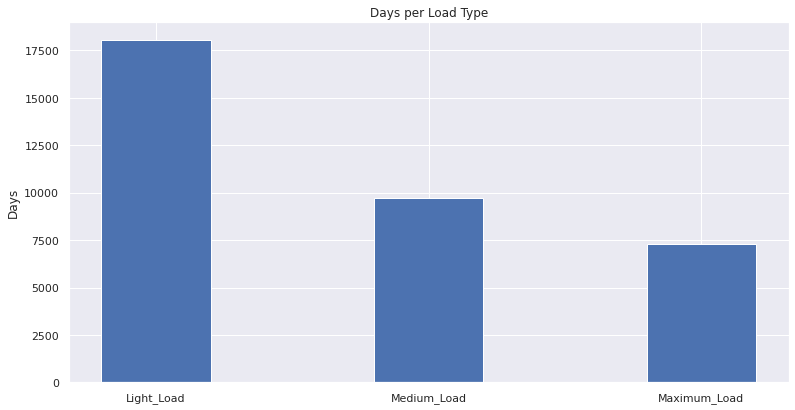

In [103]:
# Create a barplot to view how many days fall under each load type.
load_types = ['Light_Load', 'Medium_Load', 'Maximum_Load']
fig = plt.figure(figsize=(10,5))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Days per Load Type')
ax.set_ylabel('Days')
ax.bar(load_types,load_type_counts, width=0.4)
plt.show()

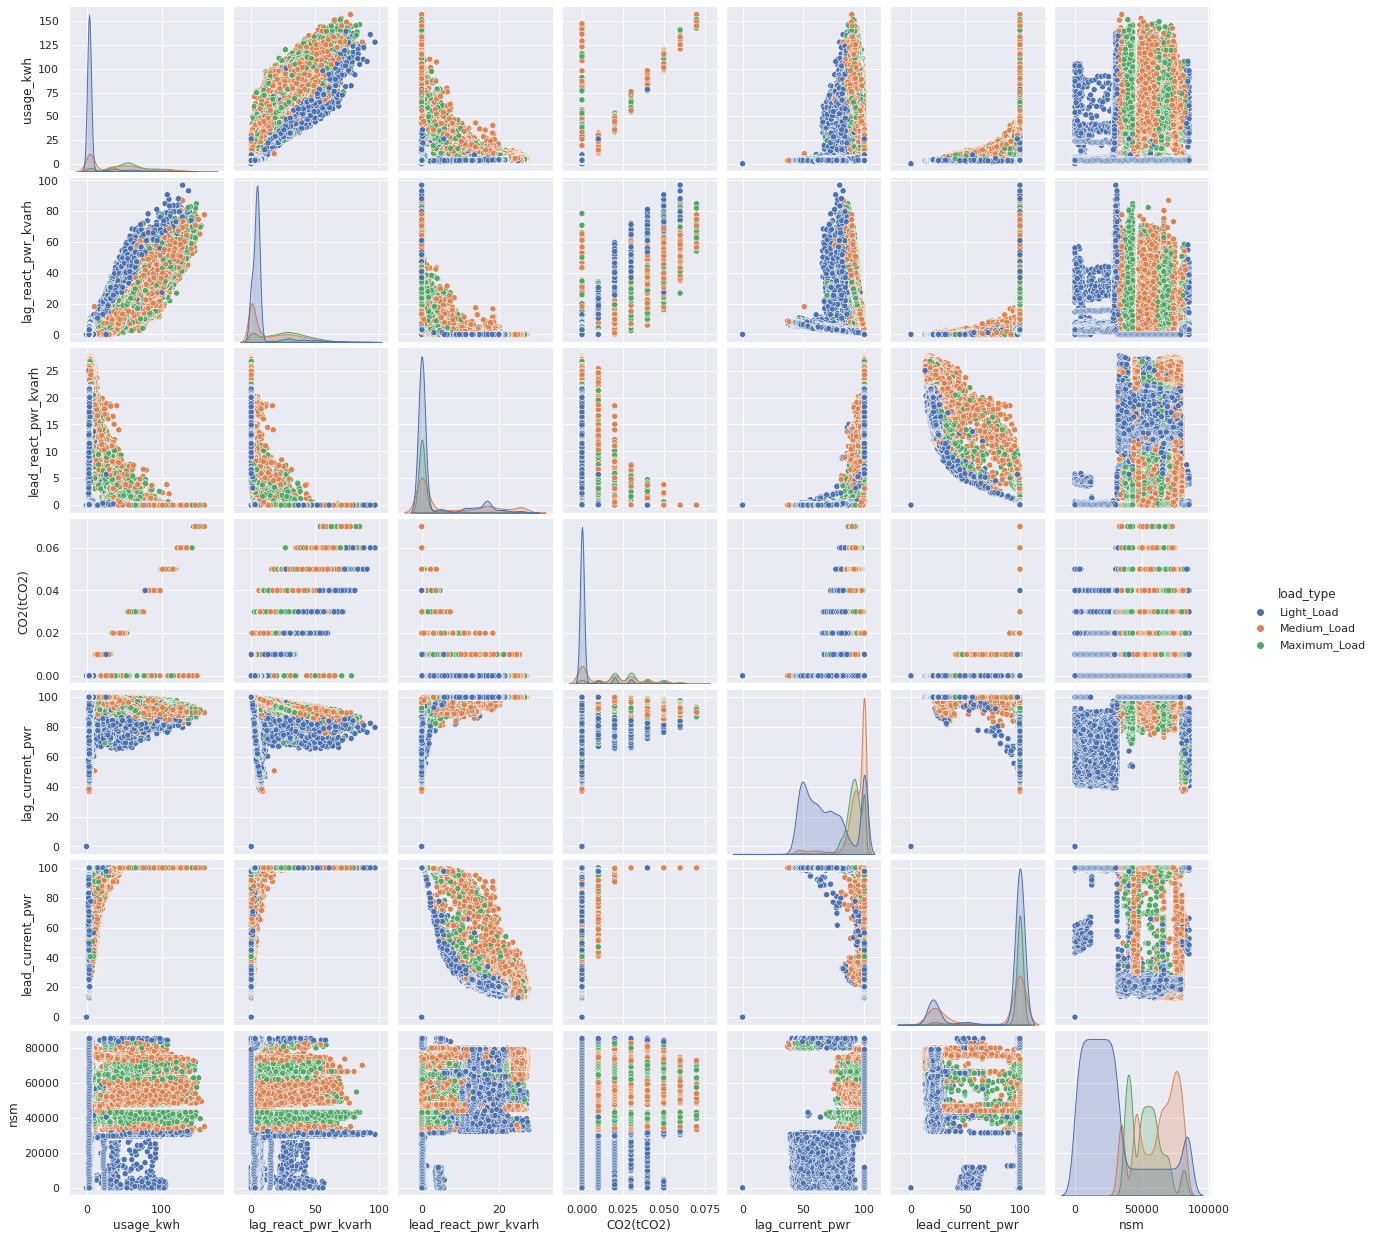

In [104]:
# Create a pairplot of all of the numerical variables using Seaborn, color-coded by load_type.
pp = sns.pairplot(df, hue='load_type')

### **Interesting patterns from the pairplot.** ###
On inspection of the scatterplots, there appears to be a significant positive correlation between `usage_kWh` and `lag_react_pwr_kVarh` and a negative correlation between `lead_current_pwr` and `lead_react_pwr_kvarh`. `CO2(tCO2)` appears to be categorical rather than continuous and finally, the data appear to be significantly clustered by load type. 

### Splitting Data into Train/Test

In [105]:
X = df.loc[:,'lag_react_pwr_kvarh':'load_type']
y = df['usage_kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

### Building the Pipeline

In [106]:
num_attribs = ['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm']
cat_attribs = ['week_status', 'day_of_week', 'load_type']
col_transform = ColumnTransformer(transformers=[
                 ('cat', OneHotEncoder(), cat_attribs),
                 ('num', MinMaxScaler(), num_attribs)],
                 remainder='passthrough')
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('mlr_model', LinearRegression())
]) 
from sklearn import set_config
set_config(display='diagram')
pipeline                             

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr_model', LinearRegression())])

### Executing the Model

In [107]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['week_status', 'day_of_week',
                                                   'load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr_model', LinearRegression())])

### Evaluating Model

In [108]:
# Make predictions on the training data.
y_train_pred = pipeline.predict(X_train)
# Make predictions on the test data.
y_pred = pipeline.predict(X_test)
# Get the root mean square errors for both 
RMSE_train = (mean_squared_error(y_train, y_train_pred))**.5
RMSE_test = (mean_squared_error(y_test, y_pred))**.5
print('RMSE_train =',RMSE_train,'  RMSE_test =',RMSE_test)

RMSE_train = 4.582075664388731   RMSE_test = 5.051067083537763


In [109]:
print('The range of usage_kwh values is from', min(df['usage_kwh']),'to', max(df['usage_kwh']))

The range of usage_kwh values is from 0.0 to 157.18


The root mean square error for the test data is approximately 10% greater than the root mean square error for the training data. This suggests that there may have been some overfitting of the training data. On the other hand, the magnitude of both errors seems acceptable given the range of target variable values (`usage_kwh` values range from 0.0 to 157.18). 

                               R-square = 0.9762917693389256



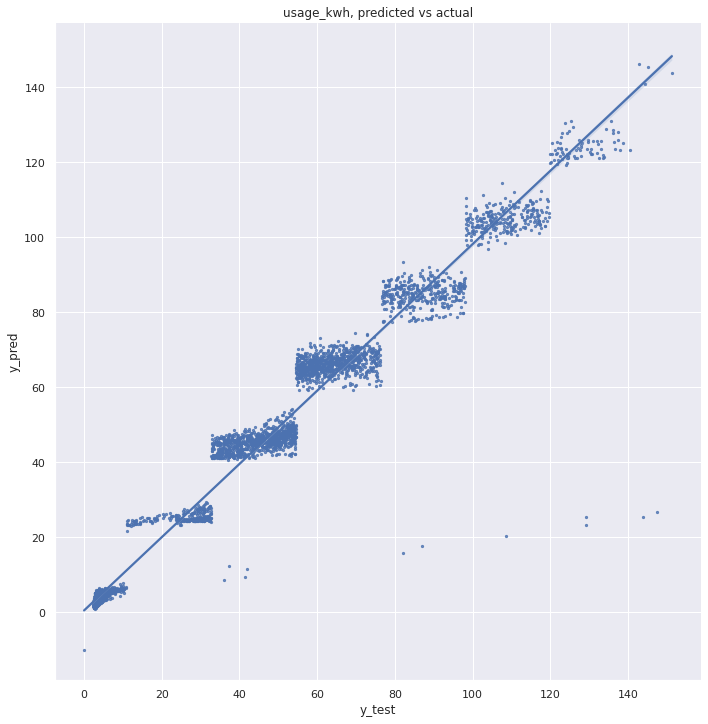

In [110]:
# Get the R-square value for the model.
r_square = r2_score(y_pred, y_test)
print('                               R-square =', r_square)
print()
# Plot predicted vs actual
data = {'y_test': y_test, 'y_pred': y_pred}
df2 = pd.DataFrame(data)
sns.set(rc = {'figure.figsize':(50,50)})
sns.lmplot(x='y_test', y='y_pred', data=df2, height=10, aspect=1, scatter_kws={"s": 5}).set(title='usage_kwh, predicted vs actual')
plt.show()

The high R-square value implies that the model fits the data well, but plotting predicted vs actual usage_kwh raises concerns. The data do not appear to be randomly distributed above and below the identity line, but instead they are segmented in a distinct pattern. In addition, there are a few outliers that also do not appear to be randomly distributed. 

In [111]:
coef = pipeline.named_steps['mlr_model'].coef_
intcpt = pipeline.named_steps['mlr_model'].intercept_
print('coefficients:')
print(coef)
print()
print('intercept:')
print(intcpt)

coefficients:
[-3.16633803e+13 -3.84634502e+13 -7.31754379e+13 -7.31754379e+13
 -6.63753679e+13 -6.63753679e+13 -7.31754379e+13 -7.31754379e+13
 -7.31754379e+13 -2.01503129e+14 -2.01503129e+14 -2.01503129e+14
  2.90178342e+01  1.88471277e+00  1.17520222e+02  6.99101919e+00
  4.70773218e+00 -3.12490463e-01]

intercept:
306341947202878.25


### Train and evaluate the model with the variable `CO2(tCO2)` excluded.

RMSE_train = 9.62489791177182   RMSE_test = 9.628305780243736
R-square = 0.9085082189051982



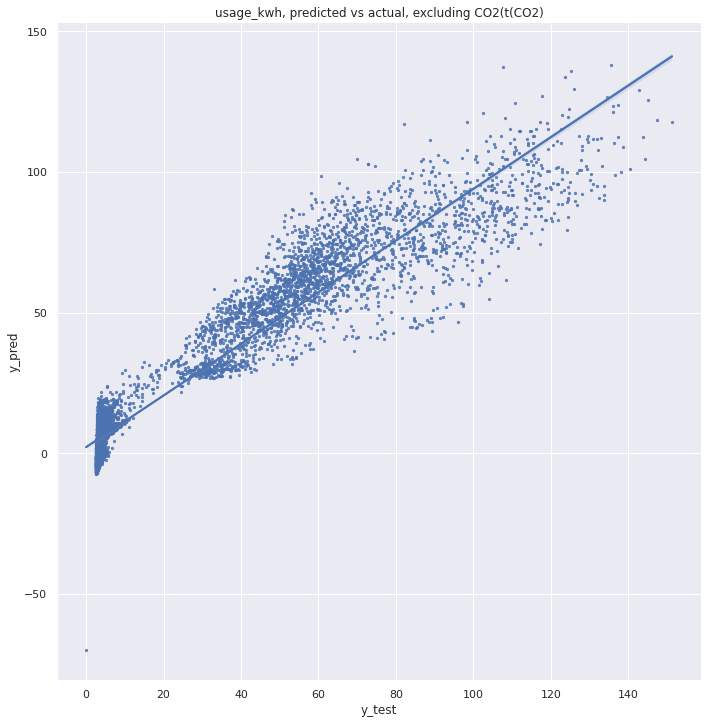

In [112]:
X = df.loc[:,'lag_react_pwr_kvarh':'load_type']
X = X.drop(['CO2(tCO2)'], axis=1)
y = df['usage_kwh']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
num_attribs = ['lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'lag_current_pwr', 'lead_current_pwr', 'nsm']
cat_attribs = ['week_status', 'day_of_week', 'load_type']
col_transform = ColumnTransformer(transformers=[
                 ('cat', OneHotEncoder(), cat_attribs),
                 ('num', MinMaxScaler(), num_attribs)],
                 remainder='passthrough')
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('mlr_model', LinearRegression())
])
pipeline.fit(X_train, y_train) 
y_train_pred = pipeline.predict(X_train)
y_pred = pipeline.predict(X_test)

# Make predictions on the training data.
y_train_pred = pipeline.predict(X_train)
# Make predictions on the test data.
y_pred = pipeline.predict(X_test)
# Get the root mean square errors for both 
RMSE_train = (mean_squared_error(y_train, y_train_pred))**.5
RMSE_test = (mean_squared_error(y_test, y_pred))**.5
print('RMSE_train =',RMSE_train,'  RMSE_test =',RMSE_test)

# Get the R-square value for the model.
r_square = r2_score(y_pred, y_test)
print('R-square =', r_square)
print()
# Plot predicted vs actual
data = {'y_test': y_test, 'y_pred': y_pred}
df2 = pd.DataFrame(data)
sns.set(rc = {'figure.figsize':(50,50)})
sns.lmplot(x='y_test', y='y_pred', data=df2, height=10, aspect=1, scatter_kws={"s": 5}).set(title='usage_kwh, predicted vs actual, excluding CO2(t(CO2)')
plt.show()

### **Conclusion**
As noted above, the R-square value for this model is quite high but that does not guarantee that the model is good. To the contrary, when the actual values are plotted against the predicted values, there is a striking pattern of segmentation which suggests that the model is biased and/or overfit. The larger RMSE for the test data compared with that of the train data is consistent with some degree of overfitting. One way to improve the model would be to reduce its complexity by eliminating one or more of the predictors (see below).<br><br>
The coefficients and intercepts are extremely large. This is the result of scaling the numeric data. The large coefficients and intercept decreased dramatically when the regression was done without scaling (not shown).<br><br>
The pairplots suggest that `CO2(tCO2)` may be categorical rather than continuous. When the model is trained excluding this variable as a predictor, the following changes are noted: the R-sqare value is lower (0.9085), but still acceptable; the marked segmentation of the predicted vs actual results is no longer present - the points are better dispersed around the identity line; the RMSE's for the test data and training data are larger - approximately double those obtained when `CO2(tCO2)` is included, but these two RMSE values are much closer to being identical, indicating less overfitting. Thus, excluding `CO2(tCO2)` results in a model that would probably perform better on out of sample data (i.e., with reduced generalization error).<br><br>
Potential additional improvements for exploration: include `CO2(tCO2)` as a categorical variable with onehot encoding; exclude `lead_current_pwr` or `lead_react_pwr_kvarh` or both since they appear to be correlated with each other on the pairplots and the predictor variables should be independent.

## Problem 2

### Reading the Data
Recode `week_status` column so that a Weekday is coded as 1 and a Weekend is coded as 0.

In [113]:
# If the week_status value is Weekday, recode to 1, otherwise recode to 0.
df['week_status'] = df['week_status'].apply(lambda x: 1 if x == 'Weekday' else 0) 

In [114]:
# Calculate proportion of instances in the dataframe where week_status is negative; i.e., week_status = 'weekend'
ws = (df.week_status.groupby(df.week_status).count())
print(ws)
print()
print('Proportion of negative week_status ("weekend") =', ws[0]/(ws[0] + ws[1]))

week_status
0     9984
1    25056
Name: week_status, dtype: int64

Proportion of negative week_status ("weekend") = 0.28493150684931506


### Splitting Data into Train/Test

In [115]:
X = df.drop(['date', 'week_status', 'day_of_week'], axis=1)
y = df['week_status'] # Target variable.
#Split the data into Train/Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)


### Building the Pipeline

In [116]:
num_attribs = ['usage_kwh', 'lag_react_pwr_kvarh', 'lead_react_pwr_kvarh', 'CO2(tCO2)', 'lag_current_pwr', 'lead_current_pwr', 'nsm']
cat_attribs = ['load_type']
col_transform = ColumnTransformer(transformers=[
                 ('cat', OneHotEncoder(), cat_attribs),
                 ('num', MinMaxScaler(), num_attribs)],
                 remainder='passthrough')
pipeline = Pipeline([
                     ('transform', col_transform),
                     ('mlr_model', LogisticRegression(max_iter=1000))
]) 
from sklearn import set_config
set_config(display='diagram')
pipeline      

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr_model', LogisticRegression(max_iter=1000))])

### Executing the Model

In [117]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['load_type']),
                                                 ('num', MinMaxScaler(),
                                                  ['usage_kwh',
                                                   'lag_react_pwr_kvarh',
                                                   'lead_react_pwr_kvarh',
                                                   'CO2(tCO2)',
                                                   'lag_current_pwr',
                                                   'lead_current_pwr',
                                                   'nsm'])])),
                ('mlr_model', LogisticRegression(max_iter=1000))])

### Evaluating Model

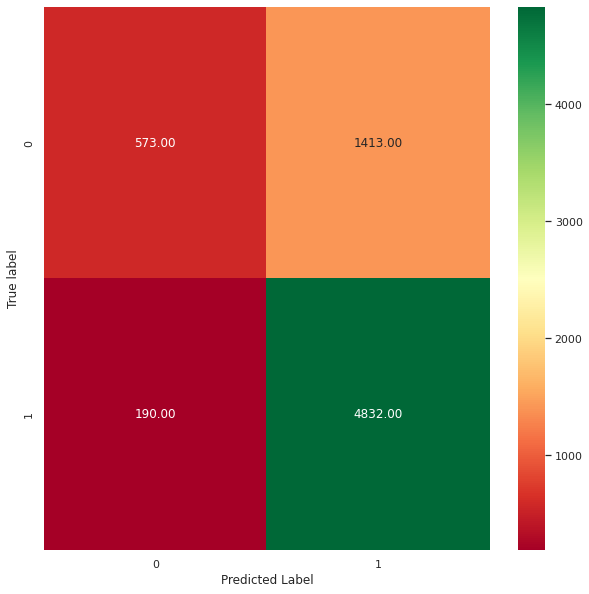

In [118]:
# Make predictions on the test data.
y_pred = pipeline.predict(X_test)
# Plot confusion matrix using plot_cm function.
plot_cm(y_test, y_pred)

In [119]:
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.7737389911929544
Recall: 0.9621664675428117
F1 score: 0.8577261027780244


This model is highly sensitive, correctly labelling 96.2% of the true positives, which was predictable given the higher proportion of positives in the outcome set. There is the expected trade-off in precision which is only 0.774. In other words, the higher sensitivity is at the expense of increased false-positives.<br><br>
The F1-score is the harmonic mean of precision and recall. It is an attempt to combine these two values into one summary statistic. F1-scores can range from 0 to 1 with the ideal value being 1. For this particular model the F1-score is 0.858 - again, acceptable but not ideal. 

                        ROC AUC: 0.7724292067571368



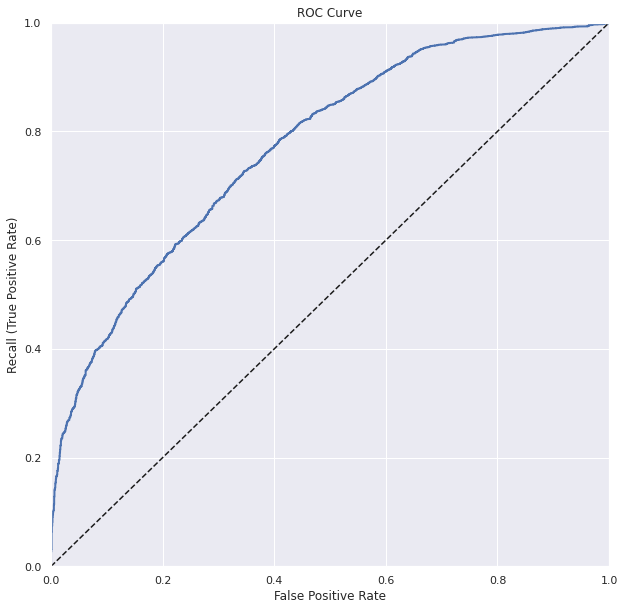

In [120]:
# Get ROC AUC and plot ROC curve.
y_pred_proba = pipeline.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
print('                        ROC AUC:',roc_auc_score(y_test, y_pred_proba))
print()
plot_roc_curve(fpr, tpr)

                    AUC Precision-Recall: 0.8929866819548715



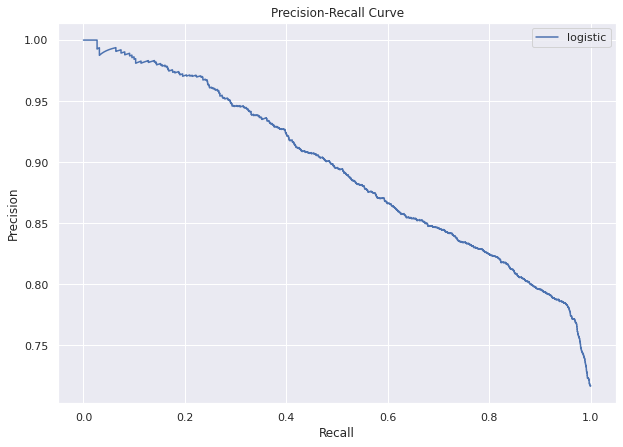

In [121]:
# Get precision-recall data.
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_proba)
# Print AUC of precision-recall curve
print('                    AUC Precision-Recall:', auc(lr_recall, lr_precision))
print()
# Plot precision vs recall
plt.figure(figsize=(10, 7))
plt.title('Precision-Recall Curve')
plt.plot(lr_recall, lr_precision, label='logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Out of interest, I chose to display both the ROC and the precision-recall curves, but because there is some degree of **class imbalance** (only 28.5% negatives), **the precision-recall curve is more appropriate for evaluating the performance of this model**. The AUC for the precision-recall curve is 0.893, which is reasonably good but not ideal. It is significantly better than the AUC for the ROC curve (0.792). The ROC curve usually provides the more optimistic assessment but just the opposite has occurred in this case, possibly because the imbalance is in the favor of the positive rather than the negative cases. In fact, if Weekends are coded as 1 instead of Weekdays, the ROC AUC does indeed provide the more optimistic assessment at 0.772 compared to a PR AUC of 0.579 (calculations for this scenario not shown).

### Conclusion
---

The suitability of this model for predicting `week_status` depends on the business case acceptability of false positives. The model is highly sensitive, correctly labelling 96.2% of the true positives (Weekdays), which was predictable given the higher proportion of positives in the data set. There is the expected trade-off in precision which is only 77.4%. This lower precision means that there will be more false-positives but if this is a business case where catching true positives outweighs the baggage of some false positives then the model is well suited.<br><br>
It was surprising to see the impact on performance when the positive and negative classes were reversed (work not shown).